In [1]:
from __future__ import print_function, division, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import OrderedDict

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import image utils
from PIL import Image

# import image processing
import scipy.ndimage as ndi
import scipy

# import image utilities
from skimage.morphology import binary_opening, disk, label, binary_closing

# import image augmentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform
)

# Import PyTorch
import torch
from torch import nn
from torch import optim
from torch.optim import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.optim import lr_scheduler

import math
import os

import time

from tqdm import tqdm_notebook

Setup the environment:
* paths to folder with data
* load csv with data
* setup the transforms

In [2]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images/'
TEST_PATH = '../input/aptos2019-blindness-detection/test_images/'

train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

train_transforms = Compose([HorizontalFlip(p=0.5),
                            CLAHE(p=1.0),
                            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.2),
                            OneOf([RandomContrast(),
                                   RandomGamma(),
                                   RandomBrightness(),], p=0.3)])

Seup the dataset:

In [3]:
class AptosDataset(Dataset):
    '''
    The dataset for APTOS data.
    '''
    def __init__(self, dataset_path, df, transforms=None, size = (299, 299), mode = 'train', indices = None):
        self.dataset_path = dataset_path
        self.df = df
        self.transforms = transforms
        self.size = size
        self.mode = mode
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        # open image and label
        idx = self.indices[idx]
        id_code = self.df.loc[idx]['id_code']
        image = Image.open(os.path.join(self.dataset_path, str(id_code) + '.png'))
        
        if self.mode == 'train' or self.mode == 'test':
            label = self.df.loc[idx]['diagnosis']
        else:
            label = None
        
        # augment image
        if self.mode == 'train':
            augmented = self.transforms(image=np.array(image))
            image = Image.fromarray(augmented['image'], 'RGB')
        
        # normalize and convert to tensor
        tf = transforms.Compose([transforms.Resize(self.size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.500, 0.500, 0.500], std=[0.500, 0.500, 0.500])])
        image = tf(image)
        
        # in validation mode return image and id_code
        if self.mode == 'validation':
            return image, id_code

        # return tensor with image and label
        return image, label
    
    def get_label(self, idx):
        if not self.mode == 'validation':
            idx = self.indices[idx]
            label = self.df.loc[idx]['diagnosis']
        else:
            return None

In [4]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.get_label(idx)
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [5]:
# weighted kappa metric

from sklearn.metrics import cohen_kappa_score

def kappa_metric(label, pred):
    pred = np.argmax(pred, axis = 1)
    return cohen_kappa_score(label, pred, weights = 'quadratic')

XceptionNet from [pretrained-models.pytorch repo](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py)

In [6]:
"""
Ported to pytorch thanks to [tstandley](https://github.com/tstandley/Xception-PyTorch)
@author: tstandley
Adapted by cadene
Creates an Xception Model as defined in:
Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf
This weights ported from the Keras implementation. Achieves the following performance on the validation set:
Loss:0.9173 Prec@1:78.892 Prec@5:94.292
REMEMBER to set your image size to 3x299x299 for both test and validation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

pretrained_settings = {
    'xception': {
        'imagenet': {
            'url': '../input/aptos-preprocessed-data/xception-43020ad28.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000,
            'scale': 0.8975 # The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
        }
    }
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = nn.ReLU(inplace=True)(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=1000, pretrained='imagenet'):
    model = Xception(num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['xception'][pretrained]

        model = Xception(num_classes=num_classes)
        model.load_state_dict(torch.load(settings['url']))

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']

    # TODO: ugly
    model.last_linear = model.fc
    del model.fc
    return model

In [7]:
# initialize pretrained XceptionNet with imagenet weights
xception_model = xception(num_classes=1000, pretrained='imagenet')

In [8]:
# wrap up pretrained XceptionNet with new fc layer
class APTOSXception(nn.Module):

    def __init__(self, xception_model, dropout = 0.3):
        super(APTOSXception, self).__init__()
        self.xception_model = xception_model
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(1000, 256)),
            ('relu1', nn.ReLU(inplace=True)),
            ('dropout1', nn.Dropout(dropout)),
            ('fc2', nn.Linear(256, 128)),
            ('bn2', nn.BatchNorm1d(num_features=128)),
            ('relu2', nn.ReLU(inplace=True)),
            ('dropout2', nn.Dropout(dropout)),
            ('fc3', nn.Linear(128, 64)),
            ('bn3', nn.BatchNorm1d(num_features=64)),
            ('relu3', nn.ReLU(inplace=True)),
            ('logits', nn.Linear(64, 5))]))
    
    def forward(self, input):
        x = self.xception_model(input)
        x = nn.ReLU(inplace=True)(x)
        x = self.classifier(x)
        
        return x

In [9]:
# initialize the model
dropout = 0.3
model = APTOSXception(xception_model, dropout = dropout)

In [10]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [11]:
# define hyperparameters
test_split = 0.2
batch_size = 32
epochs = 40
learning_rate = 0.001
num_workers = 8

In [12]:
# create dataset and data loaders
dataset_size = len(train)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_ds = AptosDataset(TRAIN_PATH, train, transforms=train_transforms, size = (299, 299), mode = 'train', indices = train_indices)
test_ds = AptosDataset(TRAIN_PATH, train, transforms=None, size = (299, 299), mode = 'test', indices = test_indices)

train_sampler = ImbalancedDatasetSampler(train_ds)
test_sampler = ImbalancedDatasetSampler(test_ds)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [13]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
for param in model.xception_model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy', 'Kappa train', 'Kappa test']) 

In [14]:
def train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats):
    #train the model
    model.to(device)
    
    # learning rate cosine annealing
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader), eta_min=0.000001)

    steps = 0
    running_loss = 0
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        top3_train_accuracy = 0 
        kappa_train = 0
        
        for inputs, labels in tqdm_notebook(trainloader):
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # calculate train top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate train top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
            # Calculate train weighted kappa metric
            kappa_train += kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())

        time_elapsed = time.time() - since

        test_loss = 0
        test_accuracy = 0
        top3_test_accuracy = 0
        kappa_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate test top-1 accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Calculate test top-3 accuracy
                np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
                target_numpy = labels.cpu().numpy()
                top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
                
                # Calculate test weighted kappa metric
                kappa_test += kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
              f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
              f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}"
              f"Weighed kappa test: {kappa_test/len(testloader):.4f}"
              f"Weighed kappa train: {kappa_train/len(trainloader):.4f}")

        train_stats = train_stats.append({'Epoch': epoch + 1, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader), 'Kappa train':kappa_train/len(trainloader), 'Kappa test':kappa_test/len(testloader)}, ignore_index=True)

        running_loss = 0
        model.train()
        scheduler.step()
        
    return model, train_stats

In [15]:
# train the model
model, train_stats = train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats)


Epoch 1/40.. Time per epoch: 688.0807.. Average time per step: 7.4791.. Train loss: 0.9133.. Train accuracy: 0.6745.. Top-3 train accuracy: 0.9016.. Test loss: 0.7836.. Test accuracy: 0.7253.. Top-3 test accuracy: 0.9152Weighed kappa test: 0.6332Weighed kappa train: 0.6751



Epoch 2/40.. Time per epoch: 710.1728.. Average time per step: 7.7193.. Train loss: 0.7752.. Train accuracy: 0.7066.. Top-3 train accuracy: 0.9444.. Test loss: 0.7818.. Test accuracy: 0.7160.. Top-3 test accuracy: 0.9412Weighed kappa test: 0.6885Weighed kappa train: 0.7218



Epoch 3/40.. Time per epoch: 703.7019.. Average time per step: 7.6489.. Train loss: 0.6573.. Train accuracy: 0.7394.. Top-3 train accuracy: 0.9641.. Test loss: 0.7154.. Test accuracy: 0.7428.. Top-3 test accuracy: 0.9577Weighed kappa test: 0.7103Weighed kappa train: 0.7658



Epoch 4/40.. Time per epoch: 679.1440.. Average time per step: 7.3820.. Train loss: 0.6415.. Train accuracy: 0.7604.. Top-3 train accuracy: 0.9694.. Test loss: 0.7825.. Test accuracy: 0.7108.. Top-3 test accuracy: 0.9519Weighed kappa test: 0.6785Weighed kappa train: 0.7837



Epoch 5/40.. Time per epoch: 637.6145.. Average time per step: 6.9306.. Train loss: 0.6216.. Train accuracy: 0.7682.. Top-3 train accuracy: 0.9725.. Test loss: 0.7741.. Test accuracy: 0.7273.. Top-3 test accuracy: 0.9524Weighed kappa test: 0.7194Weighed kappa train: 0.8054



Epoch 6/40.. Time per epoch: 615.1411.. Average time per step: 6.6863.. Train loss: 0.6089.. Train accuracy: 0.7693.. Top-3 train accuracy: 0.9742.. Test loss: 0.8053.. Test accuracy: 0.7143.. Top-3 test accuracy: 0.9276Weighed kappa test: 0.6865Weighed kappa train: 0.8121



Epoch 7/40.. Time per epoch: 637.0945.. Average time per step: 6.9249.. Train loss: 0.6145.. Train accuracy: 0.7682.. Top-3 train accuracy: 0.9732.. Test loss: 0.7188.. Test accuracy: 0.7405.. Top-3 test accuracy: 0.9713Weighed kappa test: 0.7269Weighed kappa train: 0.8012



Epoch 8/40.. Time per epoch: 612.9536.. Average time per step: 6.6625.. Train loss: 0.6222.. Train accuracy: 0.7609.. Top-3 train accuracy: 0.9755.. Test loss: 0.9249.. Test accuracy: 0.6627.. Top-3 test accuracy: 0.9482Weighed kappa test: 0.6275Weighed kappa train: 0.7992



Epoch 9/40.. Time per epoch: 613.8744.. Average time per step: 6.6725.. Train loss: 0.5856.. Train accuracy: 0.7722.. Top-3 train accuracy: 0.9715.. Test loss: 0.8358.. Test accuracy: 0.6786.. Top-3 test accuracy: 0.9371Weighed kappa test: 0.7135Weighed kappa train: 0.8274



Epoch 10/40.. Time per epoch: 603.2059.. Average time per step: 6.5566.. Train loss: 0.5568.. Train accuracy: 0.7920.. Top-3 train accuracy: 0.9702.. Test loss: 0.7137.. Test accuracy: 0.7362.. Top-3 test accuracy: 0.9645Weighed kappa test: 0.7676Weighed kappa train: 0.8279



Epoch 11/40.. Time per epoch: 588.0524.. Average time per step: 6.3919.. Train loss: 0.5847.. Train accuracy: 0.7874.. Top-3 train accuracy: 0.9760.. Test loss: 0.7576.. Test accuracy: 0.7407.. Top-3 test accuracy: 0.9561Weighed kappa test: 0.7133Weighed kappa train: 0.8202



Epoch 12/40.. Time per epoch: 597.2641.. Average time per step: 6.4920.. Train loss: 0.5650.. Train accuracy: 0.7900.. Top-3 train accuracy: 0.9786.. Test loss: 0.8000.. Test accuracy: 0.6850.. Top-3 test accuracy: 0.9470Weighed kappa test: 0.7198Weighed kappa train: 0.8322



Epoch 13/40.. Time per epoch: 593.3765.. Average time per step: 6.4497.. Train loss: 0.5244.. Train accuracy: 0.8060.. Top-3 train accuracy: 0.9796.. Test loss: 0.7469.. Test accuracy: 0.7492.. Top-3 test accuracy: 0.9523Weighed kappa test: 0.7267Weighed kappa train: 0.8379



Epoch 14/40.. Time per epoch: 603.6136.. Average time per step: 6.5610.. Train loss: 0.5519.. Train accuracy: 0.7868.. Top-3 train accuracy: 0.9766.. Test loss: 0.8870.. Test accuracy: 0.6836.. Top-3 test accuracy: 0.9437Weighed kappa test: 0.6814Weighed kappa train: 0.8246



Epoch 15/40.. Time per epoch: 592.4662.. Average time per step: 6.4398.. Train loss: 0.5466.. Train accuracy: 0.7929.. Top-3 train accuracy: 0.9786.. Test loss: 0.8884.. Test accuracy: 0.6737.. Top-3 test accuracy: 0.9319Weighed kappa test: 0.6118Weighed kappa train: 0.8341



Epoch 16/40.. Time per epoch: 596.3248.. Average time per step: 6.4818.. Train loss: 0.5330.. Train accuracy: 0.8011.. Top-3 train accuracy: 0.9786.. Test loss: 0.8279.. Test accuracy: 0.6825.. Top-3 test accuracy: 0.9303Weighed kappa test: 0.6341Weighed kappa train: 0.8401



Epoch 17/40.. Time per epoch: 611.7525.. Average time per step: 6.6495.. Train loss: 0.5175.. Train accuracy: 0.7998.. Top-3 train accuracy: 0.9817.. Test loss: 0.8574.. Test accuracy: 0.6962.. Top-3 test accuracy: 0.9425Weighed kappa test: 0.6879Weighed kappa train: 0.8221



Epoch 18/40.. Time per epoch: 617.1751.. Average time per step: 6.7084.. Train loss: 0.5232.. Train accuracy: 0.8082.. Top-3 train accuracy: 0.9840.. Test loss: 0.7953.. Test accuracy: 0.6861.. Top-3 test accuracy: 0.9455Weighed kappa test: 0.6941Weighed kappa train: 0.8571



Epoch 19/40.. Time per epoch: 629.8618.. Average time per step: 6.8463.. Train loss: 0.5085.. Train accuracy: 0.8127.. Top-3 train accuracy: 0.9796.. Test loss: 0.7907.. Test accuracy: 0.6962.. Top-3 test accuracy: 0.9358Weighed kappa test: 0.7258Weighed kappa train: 0.8554



Epoch 20/40.. Time per epoch: 634.8903.. Average time per step: 6.9010.. Train loss: 0.5011.. Train accuracy: 0.8079.. Top-3 train accuracy: 0.9837.. Test loss: 0.8078.. Test accuracy: 0.6941.. Top-3 test accuracy: 0.9482Weighed kappa test: 0.6479Weighed kappa train: 0.8367



Epoch 21/40.. Time per epoch: 619.9755.. Average time per step: 6.7389.. Train loss: 0.4880.. Train accuracy: 0.8129.. Top-3 train accuracy: 0.9864.. Test loss: 0.8461.. Test accuracy: 0.6871.. Top-3 test accuracy: 0.9495Weighed kappa test: 0.6541Weighed kappa train: 0.8514



Epoch 22/40.. Time per epoch: 623.1626.. Average time per step: 6.7735.. Train loss: 0.4648.. Train accuracy: 0.8304.. Top-3 train accuracy: 0.9810.. Test loss: 0.8357.. Test accuracy: 0.7234.. Top-3 test accuracy: 0.9523Weighed kappa test: 0.7191Weighed kappa train: 0.8626



Epoch 23/40.. Time per epoch: 642.5793.. Average time per step: 6.9846.. Train loss: 0.4922.. Train accuracy: 0.8171.. Top-3 train accuracy: 0.9813.. Test loss: 0.8084.. Test accuracy: 0.7114.. Top-3 test accuracy: 0.9521Weighed kappa test: 0.7061Weighed kappa train: 0.8556



Epoch 24/40.. Time per epoch: 640.5712.. Average time per step: 6.9627.. Train loss: 0.4555.. Train accuracy: 0.8282.. Top-3 train accuracy: 0.9864.. Test loss: 0.9140.. Test accuracy: 0.6885.. Top-3 test accuracy: 0.9371Weighed kappa test: 0.6570Weighed kappa train: 0.8535



Epoch 25/40.. Time per epoch: 640.3220.. Average time per step: 6.9600.. Train loss: 0.4562.. Train accuracy: 0.8269.. Top-3 train accuracy: 0.9878.. Test loss: 1.0715.. Test accuracy: 0.6357.. Top-3 test accuracy: 0.9057Weighed kappa test: 0.6411Weighed kappa train: 0.8646



Epoch 26/40.. Time per epoch: 633.9766.. Average time per step: 6.8910.. Train loss: 0.4488.. Train accuracy: 0.8311.. Top-3 train accuracy: 0.9848.. Test loss: 0.7716.. Test accuracy: 0.7484.. Top-3 test accuracy: 0.9493Weighed kappa test: 0.7367Weighed kappa train: 0.8592



Epoch 27/40.. Time per epoch: 655.5854.. Average time per step: 7.1259.. Train loss: 0.4429.. Train accuracy: 0.8358.. Top-3 train accuracy: 0.9844.. Test loss: 0.8101.. Test accuracy: 0.7009.. Top-3 test accuracy: 0.9468Weighed kappa test: 0.6678Weighed kappa train: 0.8640



Epoch 28/40.. Time per epoch: 663.1519.. Average time per step: 7.2082.. Train loss: 0.4435.. Train accuracy: 0.8324.. Top-3 train accuracy: 0.9864.. Test loss: 0.7478.. Test accuracy: 0.7457.. Top-3 test accuracy: 0.9577Weighed kappa test: 0.7538Weighed kappa train: 0.8589



Epoch 29/40.. Time per epoch: 672.7934.. Average time per step: 7.3130.. Train loss: 0.4493.. Train accuracy: 0.8321.. Top-3 train accuracy: 0.9828.. Test loss: 0.8091.. Test accuracy: 0.7015.. Top-3 test accuracy: 0.9606Weighed kappa test: 0.6939Weighed kappa train: 0.8647



Epoch 30/40.. Time per epoch: 648.0016.. Average time per step: 7.0435.. Train loss: 0.4257.. Train accuracy: 0.8437.. Top-3 train accuracy: 0.9898.. Test loss: 0.9321.. Test accuracy: 0.6817.. Top-3 test accuracy: 0.9274Weighed kappa test: 0.6831Weighed kappa train: 0.8775



Epoch 31/40.. Time per epoch: 671.1811.. Average time per step: 7.2954.. Train loss: 0.4265.. Train accuracy: 0.8412.. Top-3 train accuracy: 0.9848.. Test loss: 0.8123.. Test accuracy: 0.7112.. Top-3 test accuracy: 0.9484Weighed kappa test: 0.7060Weighed kappa train: 0.8634



Epoch 32/40.. Time per epoch: 662.4949.. Average time per step: 7.2010.. Train loss: 0.4238.. Train accuracy: 0.8486.. Top-3 train accuracy: 0.9875.. Test loss: 0.8356.. Test accuracy: 0.7395.. Top-3 test accuracy: 0.9592Weighed kappa test: 0.7400Weighed kappa train: 0.8764


In [16]:
# view training stats
train_stats.head()

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Train top-3 accuracy,Test loss,Test accuracy,Test top-3 accuracy,Kappa train,Kappa test
0,1.0,688.080704,7.479138,0.913315,0.674479,0.901570,0.783623,0.725349,0.915179,0.675063,0.633207
1,2.0,710.172758,7.719269,0.775160,0.706635,0.944444,0.781789,0.716033,0.941188,0.721805,0.688489
2,3.0,703.701927,7.648934,0.657344,0.739357,0.964070,0.715392,0.742818,0.957686,0.765828,0.710310
3,4.0,679.144036,7.382000,0.641521,0.760417,0.969429,0.782528,0.710792,0.951863,0.783680,0.678467
4,5.0,637.614516,6.930593,0.621635,0.768229,0.972486,0.774120,0.727290,0.952446,0.805423,0.719418


validate the model:

In [17]:
valid_ds = AptosDataset(TEST_PATH, test, transforms=None, size = (299, 299), mode = 'validation')
validloader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, num_workers=4)

NameError: name 'dataset' is not defined

In [18]:
submission = {'id_code': [], 'diagnosis': []}

model.eval()
torch.cuda.empty_cache()

for X, id_codes in tqdm_notebook(validloader):
    X = Variable(X).cuda()
    output = model(X)
    
    for i, id_code in enumerate(id_codes):
        top_p, top_class = output[i].topk(1)
        diagnosis = top_class.cpu().numpy()
        
        submission['id_code'].append(id_code)
        submission['diagnosis'].append(diagnosis[0])

NameError: name 'validloader' is not defined

In [19]:
submission_df = pd.DataFrame(submission, columns=['id_code', 'diagnosis'])
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(10)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ValueError: a must be greater than 0 unless no samples are taken

In [20]:
diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [21]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(10,20), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(list(diagnosis_dict.values()));
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

    plt.show()

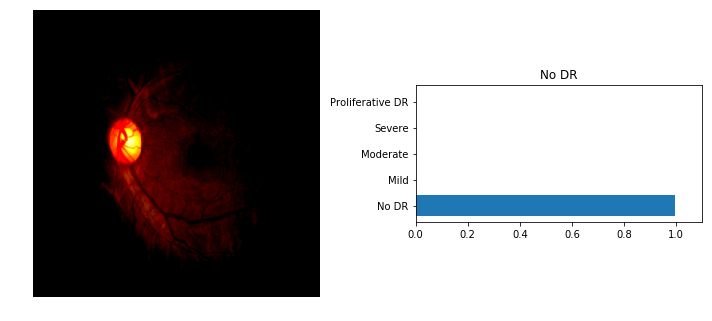

In [22]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), diagnosis_dict[int(label_true.cpu().numpy())])
    
    break;

In [23]:
# save the model

checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, 'Xception.pth')

In [24]:
# save training stats
train_stats.to_csv('Xception_train_stats.csv', index=False)